https://myjourneyasadatascientist.com/tag/statsmodels/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
linreg = LinearRegression()

In [2]:
plt.style.use('ggplot')
df = pd.read_pickle('cleaned_data')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     17848 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
delta_lot        21597 non-null int32
delta_living     21597 non-null int3

In [3]:
df.view.value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [4]:
df.view.fillna(0, inplace = True)
df.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront          0
view                0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3749
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
delta_lot           0
delta_living        0
dtype: int64

I will drop yr_renovted. It has given me much grief.

In [5]:
df.drop('yr_renovated', axis=1, inplace=True)

In [6]:
df_pred = df.drop(['id'], axis=1)

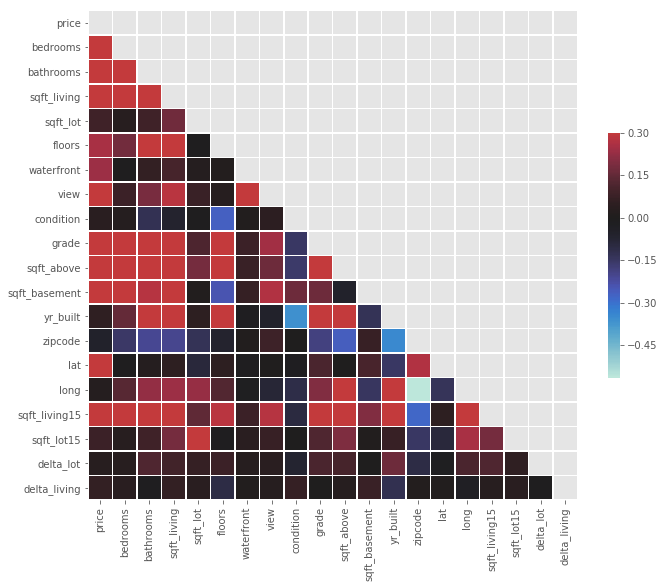

In [7]:
corr = df_pred.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [8]:
log_lot15 = np.log(df_pred.sqft_lot15) #Using the the log transformation to reduce postive skewness
log_above = np.log(df_pred.sqft_above)
#norm_basement = (df_pred.sqft_basement - df_pred.sqft_basement.mean()) / df_pred.sqft_basement.std() #I can't find anything that works #Basement has zero in it so we can't use log, we will use something else
log_living = np.log(df_pred.sqft_living)
log_living15 = np.log(df_pred.sqft_living15)
log_lot = np.log(df_pred.sqft_lot)

scaled_lot15 = (log_lot15-np.mean(log_lot15))/np.sqrt(np.var(log_lot15))
scaled_above = (log_above-np.mean(log_above))/np.sqrt(np.var(log_above))
#scaled_basement = (log_basement-np.mean(log_basement))/np.sqrt(np.var(log_basement))
scaled_living = (log_living-np.mean(log_living))/np.sqrt(np.var(log_living))
scaled_living15 = (log_living15-np.mean(log_living15))/np.sqrt(np.var(log_living15))
scaled_lot = (log_lot-np.mean(log_lot))/np.sqrt(np.var(log_lot))


df_pred_scaled = df_pred[['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'zipcode', 'waterfront', 'yr_built', 'grade', 'price']] #adding the catigorical data + target so I can remove the rows concerning outliers
df_pred_scaled['lot15'] = scaled_lot15
df_pred_scaled['above'] = scaled_above
#df_pred_scaled['basement'] = norm_basement
df_pred_scaled['living'] = scaled_living
df_pred_scaled['living15'] = scaled_living15
df_pred_scaled['lot'] = scaled_lot

C:\Users\J\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\J\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\J\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

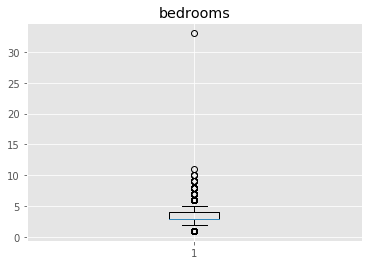

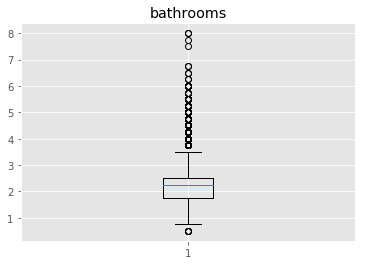

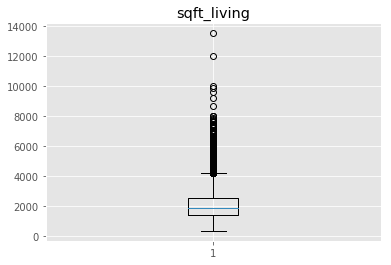

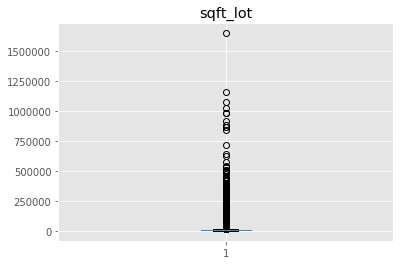

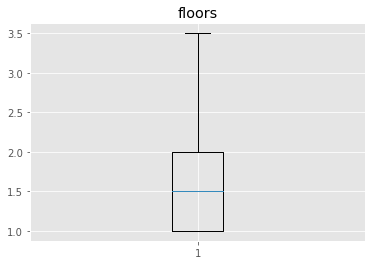

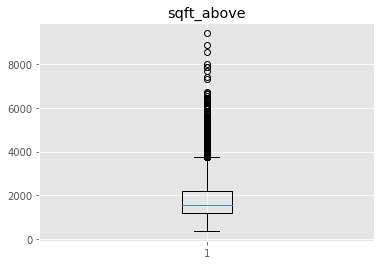

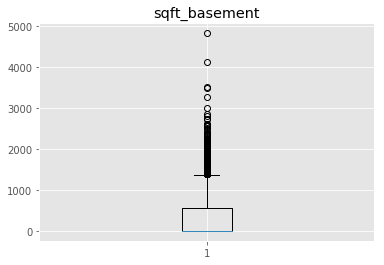

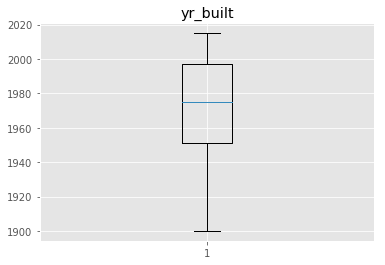

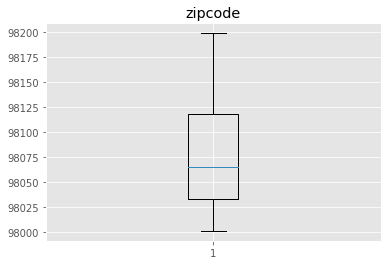

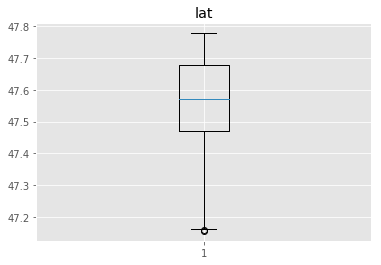

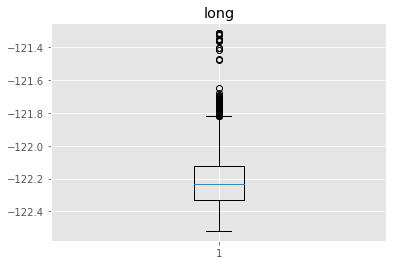

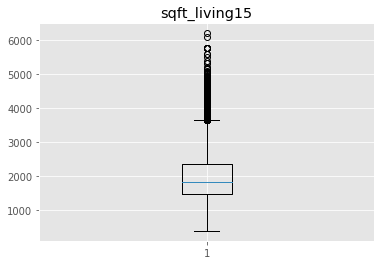

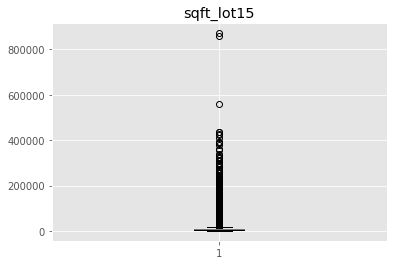

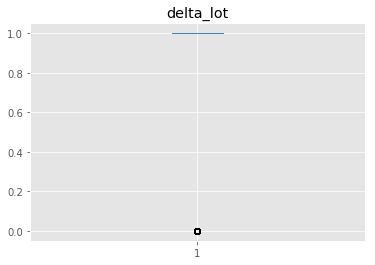

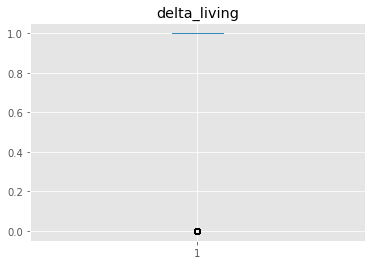

In [9]:
to_plot = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'sqft_above',
       'sqft_basement', 'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15', 'delta_lot', 'delta_living']
for plot in to_plot:
    plt.boxplot(df_pred[plot])
    plt.title(plot)
    plt.show()

There seems to be a few outliers we have to remove. I will use the IQR to take care of them. Why? well I am really unsure. Do I do them on the standarized data or no? YES, you normalize then remove the outliers

In [10]:
def remove_outlier(df_in, col_names):
    df_out = df_in
    for col in col_names:
        q1 = df_in[col].quantile(0.25)
        q3 = df_in[col].quantile(0.75)
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df_out = df_in.loc[(df_in[col] > fence_low) & (df_in[col] < fence_high)]
    return df_out

In [11]:
sliming = ['living', 'lot', 'above', 'living15', 'lot15']
df_slim = remove_outlier(df_pred_scaled, sliming)
df_slim.columns, df_slim.shape

(Index(['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'zipcode',
        'waterfront', 'yr_built', 'grade', 'price', 'lot15', 'above', 'living',
        'living15', 'lot'],
       dtype='object'), (19110, 15))

In [12]:
df_slim['price'] = np.log(df_slim.price)

bedroom_dummies = pd.get_dummies(df_slim.bedrooms, prefix="bedroom")
bathroom_dummies = pd.get_dummies(df_slim.bathrooms, prefix='bathrooms')
floors_dummies = pd.get_dummies(df_slim.floors, prefix="floors")
view_dummies = pd.get_dummies(df_slim.view, prefix="view")
condition_dummies = pd.get_dummies(df_slim.condition, prefix="condition")
zipcode_dummies = pd.get_dummies(df_slim.zipcode, prefix="zip")
grade_dummies = pd.get_dummies(df_slim.grade, prefix="grade")
waterfront_dummies = pd.get_dummies(df_slim.waterfront, prefix="waterfront")
yr_built_dummies = pd.get_dummies(df_slim.yr_built, prefix="yr_built")


df_final = pd.concat([df_slim,bedroom_dummies,bathroom_dummies,floors_dummies,view_dummies,condition_dummies,zipcode_dummies,grade_dummies, waterfront_dummies, yr_built_dummies],axis=1)

df_final.drop(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'yr_built', 'zipcode'], axis=1,inplace=True)

C:\Users\J\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Finally need to make them catagorical, my dummies that is.

In [13]:
for col in df_final.iloc[:,6:]:
    df_final[col] = df_final[col].astype('category')
df_final.iloc[:,6:].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19110 entries, 0 to 21594
Columns: 255 entries, bedroom_1 to yr_built_2015
dtypes: category(255)
memory usage: 4.8 MB


## Lets check our inital model.

First I normalize my data, then I do the following steps

Replace feature_cols & X <br>
Train_test_split your data <br>
Fit the model to linreg again using linreg.fit <br>
Make predictions using (y_pred = linreg.predict(X_test)) <br>
Compute RMSE <br>
Repeat until RMSE satisfactory <br>

In [14]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

y = df_final.price
X = df_final.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) #I couldn't figure out Kfolds well enough to use it.

#cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring="neg_mean_squared_error")
#cv_5_results

#predictors_int = sm.add_constant(X_train)
#model = sm.OLS(y_train, X_train).fit()
#model.summary()

In [27]:
from sklearn.linear_model import Lasso

lasso001 = Lasso(alpha=0.01, max_iter=10e5)
lasso001.fit(X_train,y_train)

train_score001=lasso001.score(X_train,y_train)
test_score001=lasso001.score(X_test,y_test) #This score is R^2
coeff_used001 = np.sum(lasso001.coef_!=0)


In [33]:
train_score001, test_score001 ,coeff_used001

(0.5530382491238832, 0.5497548476846577, 15)

A bit low. Lets try some different alphas

In [37]:

lasso0001 = Lasso(alpha=0.001, max_iter=10e5)
lasso0001.fit(X_train,y_train)

train_score0001=lasso0001.score(X_train,y_train)
test_score0001=lasso0001.score(X_test,y_test) #This score is R^2
coeff_used0001 = np.sum(lasso0001.coef_!=0)

In [38]:
train_score0001, test_score0001 ,coeff_used0001

(0.8620344421756119, 0.8631167061842027, 84)

In [47]:
temp = lasso001.coef_
pd.DataFrame(list(zip(X_train.columns, temp))) #Gives me what I want.


,0,1
0,lot15,-0.051435
1,above,0.000000
2,living,0.263722
3,living15,0.128569
4,lot,-0.038839
5,bedroom_1,0.000000
6,bedroom_2,0.046816
7,bedroom_3,-0.000000
8,bedroom_4,-0.000000
9,bedroom_5,0.000000


In [15]:
import statsmodels.formula.api as smf

In [16]:
col_names = ['lot15','above','living','living15', 'lot']
results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value' ]]
for idx, val in enumerate(col_names):
    f = 'price~' + str(val)
    model = smf.ols(f,df_final)
    details = model.fit()
    results.append([val, details.rsquared, details.params[0], details.params[1], details.pvalues[1] ])
pd.DataFrame(results)

,0,1,2,3,4
0,ind_var,r_squared,intercept,slope,p-value
1,lot15,0.00349891,13.0395,0.0559809,2.75292e-16
2,above,0.324378,13.0428,0.310585,0
3,living,0.445845,13.0403,0.362179,0
4,living15,0.366141,13.04,0.33097,0
5,lot,0.00539893,13.0396,0.0601851,2.68476e-24


In [17]:
#to stop the smf.ols model from failing due to the formatting. It didn't like decimals
df_final.columns = df_final.columns.str.replace('.','_')

In [18]:
cols_bedrooms = df_final.iloc[:,6:17] #removed one from every catagory to ensure to avoid signularity. 
cols_bathrooms = df_final.iloc[:,19:45]
cols_floors = df_final.iloc[:,46:51]
cols_view = df_final.iloc[:,53:56]
cols_condition = df_final.iloc[:,58:61]
cols_zip = df_final.iloc[:,63:131]
cols_waterfront = df_final.iloc[:,143:144]
cols_yr_built = df_final.iloc[:,146:]


cols = [cols_bedrooms, cols_bathrooms, cols_floors, cols_view, cols_condition, cols_zip, cols_waterfront, cols_yr_built]
for col in cols:
    sum_cols = "+".join(col)
    form = "price ~" + sum_cols
    print(form) #Title
    model = smf.ols(formula= form, data= df_final).fit()
    print(model.summary())

price ~bedroom_1+bedroom_2+bedroom_3+bedroom_4+bedroom_5+bedroom_6+bedroom_7+bedroom_8+bedroom_9+bedroom_10+bedroom_11
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     255.4
Date:                Mon, 26 Nov 2018   Prob (F-statistic):               0.00
Time:                        21:47:03   Log-Likelihood:                -13845.
No. Observations:               19110   AIC:                         2.771e+04
Df Residuals:                   19098   BIC:                         2.781e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-------

In [20]:
from sklearn.svm import SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

In [22]:
y = df_final[["price"]]
X = df_final.drop(["price"], axis=1)

svr = SVR(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svr, step=3)
rfecv.fit(X, np.ravel(y))

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 242


In [ ]:
from sklearn.metrics import mean_squared_error

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

# Feature Selection

In [ ]:
import statsmodels.api as sm

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [ ]:
#from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 5)
selector = selector.fit(X_train, y_train)

In [ ]:
estimators = selector.estimator_
print(estimators.coef_)
print(estimators.intercept_)

# Questions

The listed number of "bedroom"/"Bathroom" says more total square footage. <br>
How much, if any, does the location (zipcode) have on sales prices? <br>


In [ ]:
df_pred_scaled.hist(figsize=(10,10))

In [ ]:
df_pred.describe()

In [ ]:
scatter = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'delta_lot',
       'delta_living']
price = df.price
for scatt in scatter:
    plt.scatter(y=price,x= df[scatt])
    plt.title(scatt)
    plt.show()

In [ ]:
clean_up = ['sqft_living', 'sqft_lot', 'sqft_above',
       'sqft_basement', 'sqft_living15','sqft_lot15']

temp = remove_outlier(df_pred, clean_up)

In [ ]:
temp.describe()

Lets finally take care of our catigorial data.

In [ ]:
df_pred.drop('date', axis=1, inplace=True)
df_pred.columns

In [ ]:
#cols_bathrooms = [x.replace('.', '_') for x in cols_bathrooms]  #List comprehension to stop the smf.ols model from failing due to the formatting.
#cols_floors = [x.replace('.', '_') for x in cols_floors]
#cols_view = [x.replace('.', '_') for x in cols_view]      #this is just selecting the columns bathroom, floors, view that all had the same issue.